In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import prince
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, accuracy_score, log_loss, roc_curve, f1_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
import seaborn as sns
from itertools import product
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RepeatedStratifiedKFold
from statistics import mean
import tensorflow as tf
import shap
%matplotlib inline
from xgboost import XGBClassifier

In [2]:
plt.style.use("seaborn")

## Import the data

In [3]:
IND_a= pd.read_csv("../Datasets/Cameroon_2021_access.csv")
IND_u= pd.read_csv('../Datasets/Cameroon_2021_usage.csv')
y= IND_a['fin34a'].copy()
w= IND_a['wgt'].copy()
IND_a= IND_a.drop(columns=['wgt','fin34a'])
IND_u= IND_u.drop(columns=['wgt','fin34a'])

In [4]:
y.value_counts()

0    848
1    152
Name: fin34a, dtype: int64

In [5]:
sup= IND_a[IND_a.columns[:4]]
sup

,female,age,educ,inc_q
0,1,2.0,2,2
1,2,2.0,2,5
2,1,1.0,2,3
3,1,1.0,2,3
4,2,1.0,2,2
...,...,...,...,...
995,1,3.0,2,1
996,1,1.0,2,5
997,1,1.0,2,1
998,1,3.0,1,3


In [6]:
contingency_table = pd.crosstab(IND_a['age'], IND_a['inc_q'])
contingency_table

inc_q,1,2,3,4,5
age,,,,,
1.0,55,71,57,74,89
2.0,47,54,58,71,81
3.0,30,29,38,29,48
4.0,19,6,21,18,19
5.0,8,6,13,11,20
6.0,5,5,4,6,8


In [7]:
IND_a= IND_a.drop(columns= IND_a.columns[:4])
IND_u= IND_u.drop(columns= IND_u.columns[:4])

## Implementing MCA

In [8]:
mca_a = prince.MCA(n_components=9)

# Fit the MCA model to your data
mca_a.fit(IND_a)

# Transform the data into MCA coordinates
IND_a_index = mca_a.transform(IND_a)
new_column_names_a = {i: f'aPC{i+1}' for i in IND_a_index.columns}
IND_a_index = IND_a_index.rename(columns=new_column_names_a)
IND_a_index

,aPC1,aPC2,aPC3,aPC4,aPC5,aPC6,aPC7,aPC8,aPC9
0,-0.914119,0.674557,-0.045496,0.390816,-0.052552,-0.002027,0.059558,-0.017256,-0.007329
1,1.085195,0.444419,-0.535985,-0.205705,0.194184,-0.306249,0.200839,-0.602112,-0.067379
2,-0.372919,-0.300074,-0.019633,1.111545,-0.206582,0.073354,0.210441,-0.128343,-0.066690
3,-0.914119,0.674557,-0.045496,0.390816,-0.052552,-0.002027,0.059558,-0.017256,-0.007329
4,-0.914119,0.674557,-0.045496,0.390816,-0.052552,-0.002027,0.059558,-0.017256,-0.007329
...,...,...,...,...,...,...,...,...,...
995,1.067533,0.437282,-0.454486,-0.110078,0.228164,0.191804,-0.469492,-0.621095,-0.052071
996,0.943916,-0.050566,0.077441,0.156127,-0.445325,-0.310505,-0.268243,0.640623,-0.048701
997,-0.090180,-0.880063,0.064201,0.194158,-0.048231,0.008466,0.046987,-0.081378,-0.066147
998,-0.914119,0.674557,-0.045496,0.390816,-0.052552,-0.002027,0.059558,-0.017256,-0.007329


In [9]:
mca_u = prince.MCA(n_components=32)

# Fit the MCA model to your data
mca_u.fit(IND_u)

# Transform the data into MCA coordinates
IND_u_index = mca_u.transform(IND_u)
new_column_names_u = {i: f'uPC{i+1}' for i in IND_u_index.columns}
IND_u_index = IND_u_index.rename(columns=new_column_names_u)
IND_u_index

,uPC1,uPC2,uPC3,uPC4,uPC5,uPC6,uPC7,uPC8,uPC9,uPC10,...,uPC23,uPC24,uPC25,uPC26,uPC27,uPC28,uPC29,uPC30,uPC31,uPC32
0,-0.273526,-0.171182,-0.221108,0.137232,-0.052978,0.083032,-0.005806,0.276762,0.196307,-0.320205,...,0.242660,0.054152,-0.047581,0.038944,0.005211,0.057844,0.133769,0.002205,-0.033286,0.002133
1,0.414623,-0.286682,0.818963,-0.021756,-0.155576,0.038805,-0.077937,0.122559,0.132656,0.180332,...,-0.309747,0.049183,-0.124863,0.079506,-0.033527,0.043938,0.003209,-0.029344,-0.057115,0.009329
2,-0.233239,0.127037,-0.174991,-0.403150,-0.004422,0.130369,-0.184909,-0.026645,0.170752,-0.017867,...,-0.041977,-0.180092,-0.140096,0.025732,0.037280,-0.114419,0.001871,0.011239,-0.013628,-0.004583
3,-0.351424,-0.081488,-0.124167,-0.051729,0.005206,0.090240,0.094707,-0.033814,-0.043510,-0.023431,...,-0.142560,0.023984,-0.017285,-0.006607,0.073029,0.115875,0.117963,0.038973,-0.024660,0.005636
4,-0.407609,-0.165203,-0.084798,0.123509,0.055116,0.055562,0.136702,-0.029201,-0.038631,-0.082675,...,-0.090123,0.022619,-0.000966,-0.032919,-0.048808,0.016753,-0.031641,-0.014019,0.010536,0.010249
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.519320,-0.685151,0.079718,0.186585,-0.156381,-0.019203,-0.317016,-0.220898,0.326098,0.399049,...,-0.368800,0.397099,-0.502135,-0.145203,-0.033541,-0.084693,-0.069601,0.090859,-0.111601,-0.009993
996,0.963255,0.228606,-0.236164,0.213128,-0.361003,0.128146,-0.356094,0.059440,-0.428715,0.010220,...,0.072871,-0.164271,0.143998,-0.104014,-0.051229,0.016458,-0.049762,0.060618,0.019135,-0.003566
997,0.298165,0.329209,-0.572931,-0.615780,0.013899,-0.022484,-0.166620,0.493301,-0.331782,-0.080011,...,0.100786,0.180070,0.034718,0.034711,-0.078664,-0.015905,-0.052111,0.058043,-0.049903,0.002356
998,-0.331804,0.004035,-0.144197,-0.235720,0.059543,0.125987,-0.227272,-0.005815,0.196274,0.045027,...,-0.033646,-0.004657,0.021645,0.037481,0.017036,0.048458,-0.009595,-0.001593,-0.004068,0.004200


In [10]:
X = pd.concat([IND_a_index, IND_u_index, sup], axis=1)
X

,aPC1,aPC2,aPC3,aPC4,aPC5,aPC6,aPC7,aPC8,aPC9,uPC1,...,uPC27,uPC28,uPC29,uPC30,uPC31,uPC32,female,age,educ,inc_q
0,-0.914119,0.674557,-0.045496,0.390816,-0.052552,-0.002027,0.059558,-0.017256,-0.007329,-0.273526,...,0.005211,0.057844,0.133769,0.002205,-0.033286,0.002133,1,2.0,2,2
1,1.085195,0.444419,-0.535985,-0.205705,0.194184,-0.306249,0.200839,-0.602112,-0.067379,0.414623,...,-0.033527,0.043938,0.003209,-0.029344,-0.057115,0.009329,2,2.0,2,5
2,-0.372919,-0.300074,-0.019633,1.111545,-0.206582,0.073354,0.210441,-0.128343,-0.066690,-0.233239,...,0.037280,-0.114419,0.001871,0.011239,-0.013628,-0.004583,1,1.0,2,3
3,-0.914119,0.674557,-0.045496,0.390816,-0.052552,-0.002027,0.059558,-0.017256,-0.007329,-0.351424,...,0.073029,0.115875,0.117963,0.038973,-0.024660,0.005636,1,1.0,2,3
4,-0.914119,0.674557,-0.045496,0.390816,-0.052552,-0.002027,0.059558,-0.017256,-0.007329,-0.407609,...,-0.048808,0.016753,-0.031641,-0.014019,0.010536,0.010249,2,1.0,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,1.067533,0.437282,-0.454486,-0.110078,0.228164,0.191804,-0.469492,-0.621095,-0.052071,0.519320,...,-0.033541,-0.084693,-0.069601,0.090859,-0.111601,-0.009993,1,3.0,2,1
996,0.943916,-0.050566,0.077441,0.156127,-0.445325,-0.310505,-0.268243,0.640623,-0.048701,0.963255,...,-0.051229,0.016458,-0.049762,0.060618,0.019135,-0.003566,1,1.0,2,5
997,-0.090180,-0.880063,0.064201,0.194158,-0.048231,0.008466,0.046987,-0.081378,-0.066147,0.298165,...,-0.078664,-0.015905,-0.052111,0.058043,-0.049903,0.002356,1,1.0,2,1
998,-0.914119,0.674557,-0.045496,0.390816,-0.052552,-0.002027,0.059558,-0.017256,-0.007329,-0.331804,...,0.017036,0.048458,-0.009595,-0.001593,-0.004068,0.004200,1,3.0,1,3


In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state= 64)

## Logistic regression

In [12]:
lr = LogisticRegression(solver='newton-cg', max_iter=200)

#Setting the range for class weights
weights= [.01* i for i in range(1, 201)]
weights= list(product(weights, weights))

#Creating a dictionary grid for grid search
param_grid = {'class_weight': [{0:.49, 1:1.56}], 
              'C': [1]}

#Fitting grid search to the train data with 5 folds
grid_search_lr = GridSearchCV(estimator= lr, 
                          param_grid= param_grid,
                          cv=StratifiedKFold(), 
                          n_jobs=-1, 
                          scoring='f1', 
                          verbose=2).fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


In [13]:
print('Best parameters:', grid_search_lr.best_params_)
print('Best score:', grid_search_lr.best_score_)

Best parameters: {'C': 1, 'class_weight': {0: 0.49, 1: 1.56}}
Best score: 0.7869612606552495


In [14]:
best_lr = LogisticRegression(**grid_search_lr.best_params_)
best_lr.fit(X_train, y_train)

proba = best_lr.predict_proba(X_test)
y_= proba[:,1]

auc1 = roc_auc_score(y_test, y_, multi_class='auto')
print('AUC:', auc1)

# Calculate precision, recall, and F1-score
target_names = ["0", "1"]
treshold= 0.5
y_pred = (y_ >= treshold).astype(int)
print(classification_report(y_test, y_pred, target_names=target_names))

AUC: 0.9648482838666887
              precision    recall  f1-score   support

           0       0.99      0.90      0.94       163
           1       0.68      0.97      0.80        37

    accuracy                           0.91       200
   macro avg       0.84      0.93      0.87       200
weighted avg       0.94      0.91      0.92       200



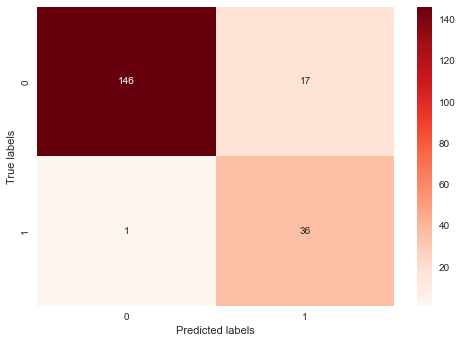

In [15]:
cm1= confusion_matrix(y_test, y_pred)
sns.heatmap(cm1, annot=True, fmt='d', cmap="Reds")

plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

In [16]:
acc_1= accuracy_score(y_test, y_pred)
pre_1= precision_score(y_test, y_pred)
rec_1= recall_score(y_test, y_pred)
f_1_1= f1_score(y_test, y_pred)

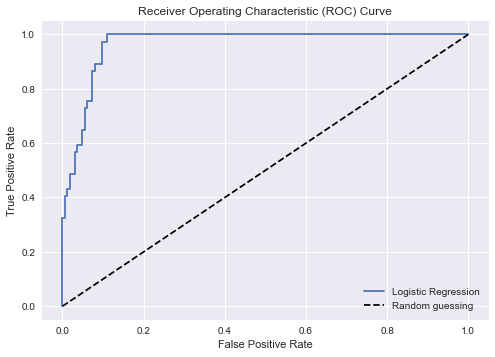

In [17]:
fpr1, tpr1, thresholds = roc_curve(y_test, y_)

# plot the ROC curve
plt.plot(fpr1, tpr1, label='Logistic Regression')
plt.plot([0, 1], [0, 1], linestyle='--', color= "k", label='Random guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

## Random Forest

In [18]:
weights= [i for i in np.linspace(0, 10,200)]
weights= list(product(weights, weights))
param_grid = {
    'n_estimators': [87],
    'max_depth': [7],
    'min_samples_split': [2],
    'min_samples_leaf': [2],
    'max_features': ['sqrt'],
    'class_weight': [{0: .55, 1:6.43}]
}
rf = RandomForestClassifier(random_state= 42)

In [19]:
grid_search_rf = GridSearchCV(estimator=rf, 
                           param_grid=param_grid, 
                           cv= StratifiedKFold(), 
                           scoring='f1', 
                           n_jobs=-1,
                           verbose=2).fit(X_train, y_train)
best_rf = RandomForestClassifier(**grid_search_rf.best_params_)
best_rf.fit(X_train, y_train)
y_pred = best_rf.predict(X_test)
proba= best_rf.predict_proba(X_test)
y_=proba[:,1]
treshold= 0.5
y_pred = (y_ >= treshold).astype(int)
print(f'Best hyperparameters: {grid_search_rf.best_params_}')
print('Best score:', grid_search_rf.best_score_)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best hyperparameters: {'class_weight': {0: 0.55, 1: 6.43}, 'max_depth': 7, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 87}
Best score: 0.7157369614512472


In [20]:
auc2 = roc_auc_score(y_test, proba[:,1], multi_class='auto')
print('AUC:', auc2)
target_names = ["0", "1"]
print(classification_report(y_test, y_pred, target_names=target_names))

AUC: 0.9295307577516166
              precision    recall  f1-score   support

           0       0.93      0.91      0.92       163
           1       0.64      0.68      0.66        37

    accuracy                           0.87       200
   macro avg       0.78      0.79      0.79       200
weighted avg       0.87      0.87      0.87       200



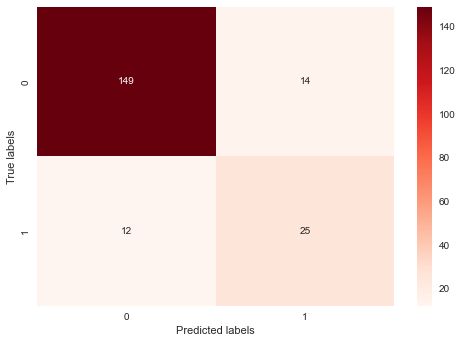

In [21]:
cm2 = confusion_matrix(y_test, y_pred)
sns.heatmap(cm2, annot=True, fmt='d', cmap="Reds")

plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

In [22]:
acc_2= accuracy_score(y_test, y_pred)
pre_2= precision_score(y_test, y_pred)
rec_2= recall_score(y_test, y_pred)
f_1_2= f1_score(y_test, y_pred)

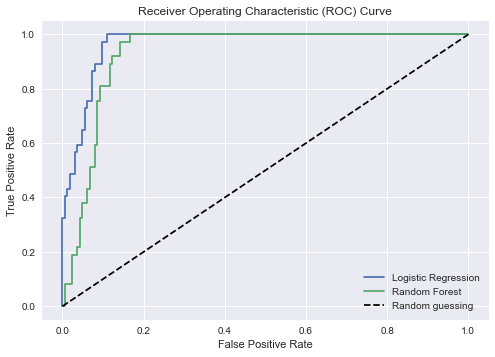

In [23]:
fpr2, tpr2, thresholds = roc_curve(y_test, y_)

# plot the ROC curve
plt.plot(fpr1, tpr1, label='Logistic Regression')
plt.plot(fpr2, tpr2, label='Random Forest')
plt.plot([0, 1], [0, 1], linestyle='--', color= "k", label='Random guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

## XG Boost

In [24]:
neg = y_train.value_counts()[0]
pos = y_train.value_counts()[1]
scale_pos_weight = neg / pos

In [25]:
xgb = XGBClassifier(scale_pos_weight=scale_pos_weight)
param_grid = {
    'max_depth': [10],
    'learning_rate': [.1],
    'n_estimators': [376],
    'subsample': [0.5],
    'colsample_bytree': [0.5],
    'reg_alpha': [0.5],
    'reg_lambda': [0.1],
}
grid_search_xgb = GridSearchCV(estimator=xgb, 
                           param_grid=param_grid, 
                           cv= StratifiedKFold(), 
                           scoring='f1', 
                           n_jobs=-1,
                           verbose=2).fit(X_train, y_train)
print("Best hyperparameters: ", grid_search_xgb.best_params_)
print("Best F1 score: ", grid_search_xgb.best_score_)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best hyperparameters:  {'colsample_bytree': 0.5, 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 376, 'reg_alpha': 0.5, 'reg_lambda': 0.1, 'subsample': 0.5}
Best F1 score:  0.7450130821559393


In [26]:
best_xgb = XGBClassifier(**grid_search_xgb.best_params_)
best_xgb.fit(X_train, y_train)
y_pred = best_xgb.predict(X_test)
proba = best_xgb.predict_proba(X_test)
y_= proba[:,1]
treshold= 0.3
y_pred = (y_ >= treshold).astype(int)

In [27]:
auc3 = roc_auc_score(y_test, y_, multi_class='auto')
print('AUC:', auc3)
target_names = ["0", "1"]
print(classification_report(y_test, y_pred, target_names=target_names))

AUC: 0.9310230475874648
              precision    recall  f1-score   support

           0       0.91      0.91      0.91       163
           1       0.61      0.62      0.61        37

    accuracy                           0.85       200
   macro avg       0.76      0.76      0.76       200
weighted avg       0.86      0.85      0.86       200



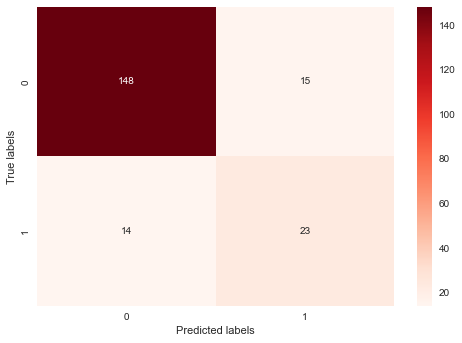

In [28]:
cm3 = confusion_matrix(y_test, y_pred)
sns.heatmap(cm3, annot=True, fmt='d', cmap="Reds")

plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

In [29]:
acc_3= accuracy_score(y_test, y_pred)
pre_3= precision_score(y_test, y_pred)
rec_3= recall_score(y_test, y_pred)
f_1_3= f1_score(y_test, y_pred)

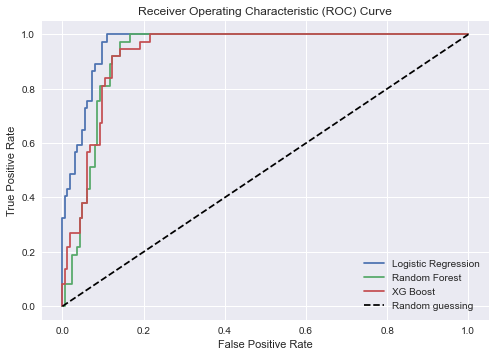

In [30]:
fpr3, tpr3, thresholds = roc_curve(y_test, y_)

# plot the ROC curve
plt.plot(fpr1, tpr1, label='Logistic Regression')
plt.plot(fpr2, tpr2, label='Random Forest')
plt.plot(fpr3, tpr3, label='XG Boost')
plt.plot([0, 1], [0, 1], linestyle='--', color= "k", label='Random guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

## Artificial Neural Network

In [31]:
ann = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [32]:
ann.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=[tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

In [33]:
history = ann.fit(X_train, y_train,
                    epochs=50,
                    batch_size=32,
                    validation_split=0.2)

Epoch 1/50
20/20 [==============================] - 2s 21ms/step - loss: 0.5209 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.4559 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/50
20/20 [==============================] - 0s 4ms/step - loss: 0.4232 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.4079 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/50
20/20 [==============================] - 0s 5ms/step - loss: 0.3772 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.3485 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/50
20/20 [==============================] - 0s 4ms/step - loss: 0.3290 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.2997 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/50
20/20 [==============================] - 0s 4ms/step - loss: 0.2858 - precision: 0.7143 - recall: 0.0549 - val_loss: 0.2596 - val_precision: 0.7500 - val_recall: 0.1250
Epoch 6/50
20/20 [=================

Epoch 46/50
20/20 [==============================] - 0s 4ms/step - loss: 0.0271 - precision: 0.9889 - recall: 0.9780 - val_loss: 0.1537 - val_precision: 0.7600 - val_recall: 0.7917
Epoch 47/50
20/20 [==============================] - 0s 4ms/step - loss: 0.0274 - precision: 0.9381 - recall: 1.0000 - val_loss: 0.1721 - val_precision: 0.8571 - val_recall: 0.7500
Epoch 48/50
20/20 [==============================] - 0s 4ms/step - loss: 0.0251 - precision: 0.9681 - recall: 1.0000 - val_loss: 0.1582 - val_precision: 0.7600 - val_recall: 0.7917
Epoch 49/50
20/20 [==============================] - 0s 4ms/step - loss: 0.0257 - precision: 0.9579 - recall: 1.0000 - val_loss: 0.1741 - val_precision: 0.8571 - val_recall: 0.7500
Epoch 50/50
20/20 [==============================] - 0s 9ms/step - loss: 0.0240 - precision: 0.9783 - recall: 0.9890 - val_loss: 0.1657 - val_precision: 0.8182 - val_recall: 0.7500


In [34]:
y_ = ann.predict(X_test)

7/7 [==============================] - 0s 3ms/step


In [35]:
y_= y_.reshape(y_.shape[0],)

In [36]:
y_pred= np.array([round(i) for i in y_])

In [37]:
auc4 = roc_auc_score(y_test, y_, multi_class='auto')
print('AUC:', auc4)
target_names = ["0", "1"]
print(classification_report(y_test, y_pred, target_names=target_names))

AUC: 0.9558945448516001
              precision    recall  f1-score   support

           0       0.91      0.94      0.92       163
           1       0.70      0.57      0.63        37

    accuracy                           0.88       200
   macro avg       0.80      0.76      0.78       200
weighted avg       0.87      0.88      0.87       200



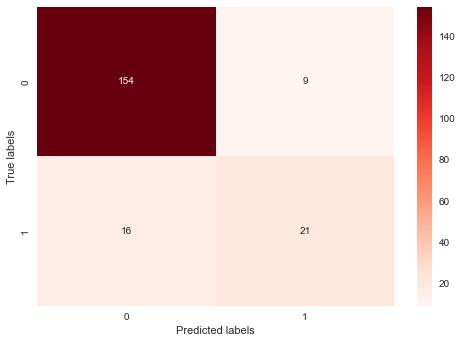

In [38]:
cm4 = confusion_matrix(y_test, y_pred)
sns.heatmap(cm4, annot=True, fmt='d', cmap="Reds")

plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

In [39]:
acc_4= accuracy_score(y_test, y_pred)
pre_4= precision_score(y_test, y_pred)
rec_4= recall_score(y_test, y_pred)
f_1_4= f1_score(y_test, y_pred)

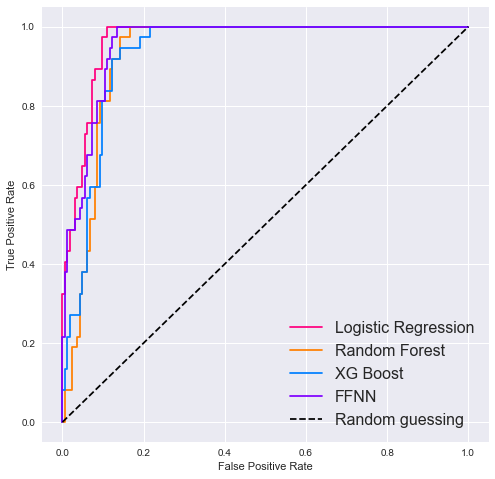

In [40]:
fpr4, tpr4, thresholds = roc_curve(y_test, y_)

# plot the ROC curve
plt.figure(figsize=(8,8))
plt.plot(fpr1, tpr1, label='Logistic Regression', color= "#ff007f")
plt.plot(fpr2, tpr2, label='Random Forest', color= "#ff7f00")
plt.plot(fpr3, tpr3, label='XG Boost', color= "#007fff")
plt.plot(fpr4, tpr4, label='FFNN', color= "#7f00ff")
plt.plot([0, 1], [0, 1], linestyle='--', color= "#000000", label='Random guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
#plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(fontsize=16)
plt.savefig("../../images/roc_cam.png")
plt.show()

## Model Evaluations

In [41]:
data= {"Metrics":["Accuracy", "Recall", "Precision", "F1-Score", "AUC"],
       "LR":[round(acc_1,4), round(rec_1,4), round(pre_1,4), round(f_1_1,4), round(auc1,4)], 
       "RF":[round(acc_2,4), round(rec_2,4), round(pre_2,4), round(f_1_2,4), round(auc2,4)], 
       "XGB":[round(acc_3,4), round(rec_3,4), round(pre_3,4), round(f_1_3,4), round(auc3,4)], 
       "FFNN":[round(acc_4,4), round(rec_4,4), round(pre_4,4), round(f_1_4,4), round(auc4,4)]}
df = pd.DataFrame(data)
latex_code = df.to_latex(index=False)

# Print the LaTeX code
print(latex_code)

\begin{tabular}{lrrrr}
\toprule
  Metrics &     LR &     RF &    XGB &   FFNN \\
\midrule
 Accuracy & 0.9100 & 0.8700 & 0.8550 & 0.8750 \\
   Recall & 0.9730 & 0.6757 & 0.6216 & 0.5676 \\
Precision & 0.6792 & 0.6410 & 0.6053 & 0.7000 \\
 F1-Score & 0.8000 & 0.6579 & 0.6133 & 0.6269 \\
      AUC & 0.9648 & 0.9295 & 0.9310 & 0.9559 \\
\bottomrule
\end{tabular}



In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.


## Build the index

In [42]:
eig_a= mca_a.eigenvalues_
IND_a_index["access"]= sum([IND_a_index[IND_a_index.columns[i]]*eig_a[i] for i in range(len(eig_a))])
eig_u= mca_u.eigenvalues_
IND_u_index["usage"]= sum([IND_u_index[IND_u_index.columns[i]]*eig_u[i] for i in range(len(eig_u)) ])

In [43]:
IND_fin= pd.concat([IND_a_index["access"], IND_u_index["usage"], sup, y], axis=1)

In [44]:
IND_fin["access"]= IND_fin["access"]*w
min(IND_fin["access"]), max(IND_fin["access"]), mean(IND_fin["access"])

(-1.1023372333024386, 3.515556021925617, -0.11544572221288928)

In [45]:
IND_fin["access"] -= min(IND_fin["access"])
IND_fin["access"] /= max(IND_fin["access"])

In [46]:
min(IND_fin["access"]), max(IND_fin["access"]), mean(IND_fin["access"])

(0.0, 1.0, 0.21371033424652242)

In [47]:
IND_fin["usage"]= IND_fin["usage"]*w
min(IND_fin["usage"]), max(IND_fin["usage"]), mean(IND_fin["usage"])

(-0.37796140861498023, 1.092689279721037, -0.019360588694778025)

In [48]:
IND_fin["usage"] -= min(IND_fin["usage"])
IND_fin["usage"] /= max(IND_fin["usage"])

In [49]:
#IND_fin["access"] = 1- IND_fin["access"]
#IND_fin["usage"] = 1- IND_fin["usage"]

In [50]:
IND_fin["index"]= (IND_fin['access'] + IND_fin['usage'])/2

In [51]:
fin_0= IND_fin[IND_fin["fin34a"]==0].copy()
fin_1= IND_fin[IND_fin["fin34a"]==1].copy()

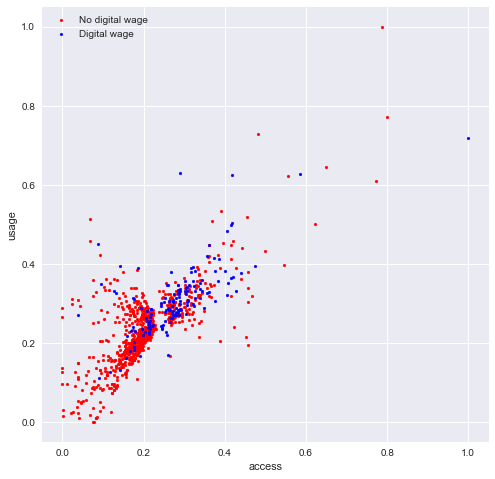

In [52]:
plt.figure(figsize=(8,8))
plt.scatter(fin_0["access"], fin_0["usage"], label= "No digital wage", s=32, color="#ff0000",
            marker='.')
plt.scatter(fin_1["access"], fin_1["usage"], label= "Digital wage", s=32, color="#0000ff",
            marker='.')
plt.xlabel("access")
plt.ylabel("usage")
plt.legend()
#plt.xlim([0.25,1.05])
#plt.ylim([-0.05,.75])
plt.savefig('../../images/find_cam')
plt.show()

In [53]:
IND_fin['access'].describe()

count    1000.000000
mean        0.213710
std         0.093631
min         0.000000
25%         0.169078
50%         0.201542
75%         0.260235
max         1.000000
Name: access, dtype: float64

In [54]:
IND_fin['usage'].describe()

count    1000.000000
mean        0.243838
std         0.092496
min         0.000000
25%         0.194441
50%         0.235976
75%         0.288352
max         1.000000
Name: usage, dtype: float64

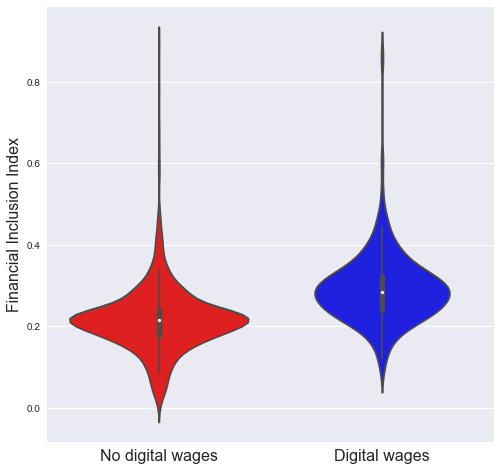

In [55]:
colors = ["#ff0000", "#0000ff"]
plt.figure(figsize=(8, 8))
sns.violinplot(x='fin34a', y='index', data=IND_fin, palette= colors)
custom_category_names = ['No digital wages', 'Digital wages']
plt.xticks(range(len(custom_category_names)), custom_category_names, fontsize=16)
plt.xlabel('')
plt.ylabel('Financial Inclusion Index', fontsize=16)

plt.savefig('../../images/ind_cam')

# Show the plot
plt.show()

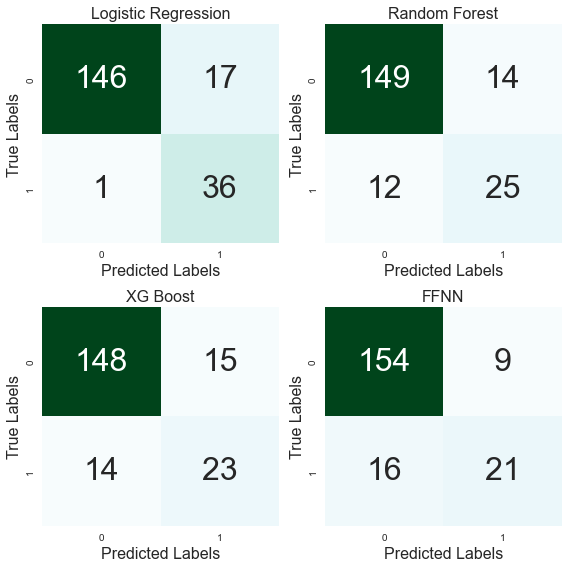

In [56]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 8))
cm= [cm1, cm2, cm3, cm4]
mods= ["Logistic Regression", "Random Forest", "XG Boost", "FFNN"]
# Compute and plot confusion matrices
for i, ax in enumerate(axes.flatten()):
    sns.heatmap(cm[i], annot=True, cmap='BuGn', fmt='d', ax=ax, cbar=False, 
                annot_kws={"fontsize": 32})
    ax.set_title(f"{mods[i]}", fontsize=16)
    ax.set_xlabel("Predicted Labels", fontsize=16)
    ax.set_ylabel("True Labels", fontsize=16)

# Adjust subplot spacing
plt.tight_layout()
plt.savefig('../../images/comat_cam.png')
# Display the plot
plt.show()

## Feature Importance

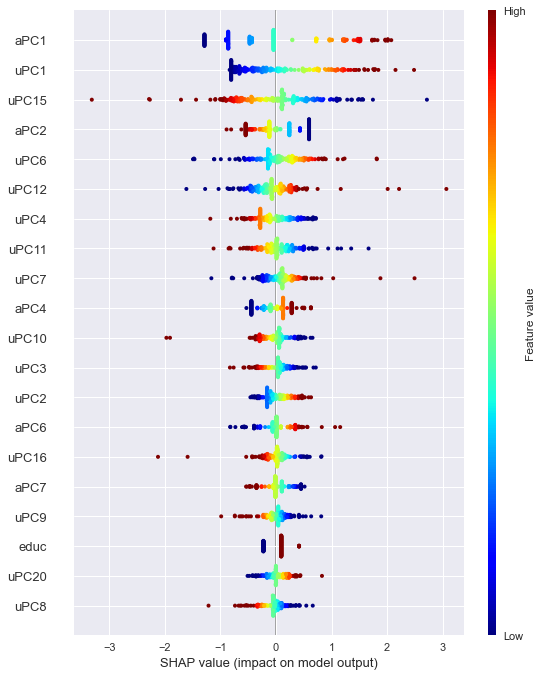

In [65]:
explainer = shap.Explainer(best_lr, X_train)

# calculate shap values. This is what we will plot.
# Calculate shap_values for all of val_X rather than a single row, to have more data for plot.
shap_values = explainer.shap_values(X_test)

# Make plot. Index of [1] is explained in text below.
shap.summary_plot(shap_values, X_test, cmap= "jet")

In [58]:
u= mca_u.column_contributions_
u= u.rename(columns=new_column_names_u)
a= mca_a.column_contributions_
a= a.rename(columns=new_column_names_a)

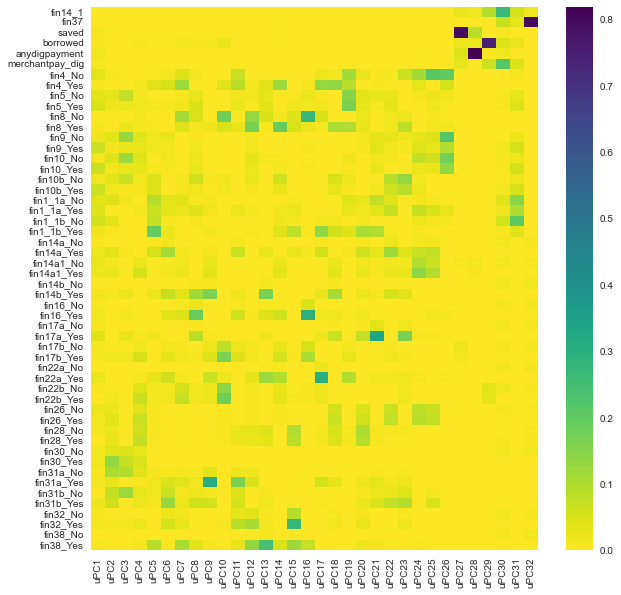

In [59]:
plt.figure(figsize=(10,10))
sns.heatmap(u, annot=False, cmap="viridis_r", cbar=True)#, annot_kws={"fontsize": 32})
plt.savefig('../../images/us_cam.png')
plt.show()

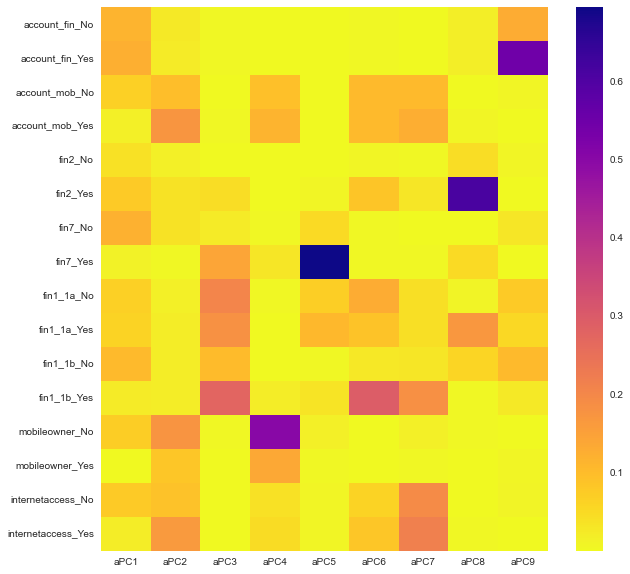

In [60]:
plt.figure(figsize=(10,10))
sns.heatmap(a, annot=False, cmap="plasma_r", cbar=True)#, annot_kws={"fontsize": 32})
plt.savefig('../../images/acc_cam.png')
plt.show()

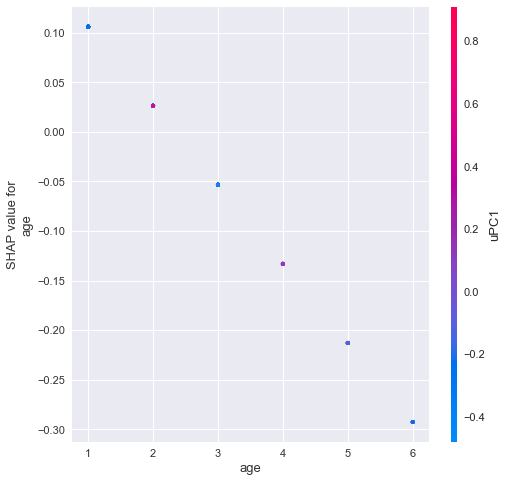

In [61]:
fig, ax= plt.subplots(figsize=(8,8))
shap.dependence_plot('age', shap_values, X_test, interaction_index="uPC1", ax=ax)
plt.show()

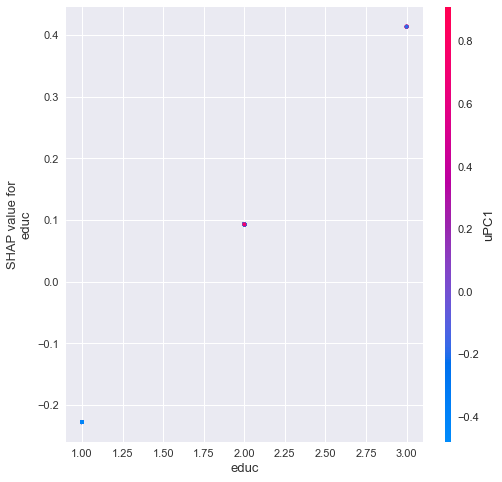

In [62]:
fig, ax= plt.subplots(figsize=(8,8))
shap.dependence_plot('educ', shap_values, X_test, interaction_index="uPC1", ax=ax)
plt.show()

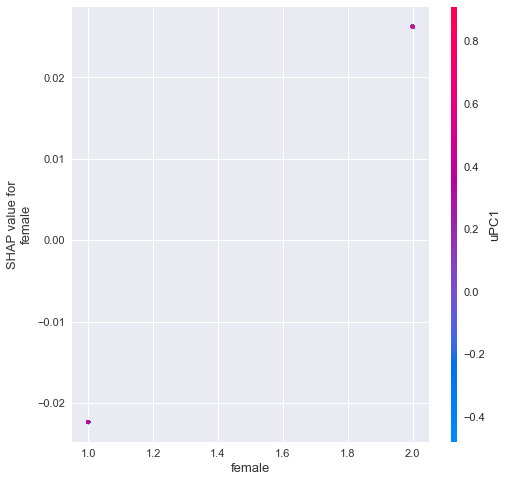

In [63]:
fig, ax= plt.subplots(figsize=(8,8))
shap.dependence_plot('female', shap_values, X_test, interaction_index="uPC1", ax=ax)
plt.show()

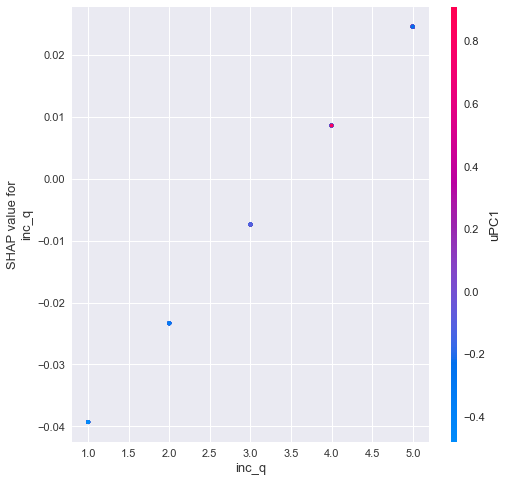

In [64]:
fig, ax= plt.subplots(figsize=(8,8))
shap.dependence_plot('inc_q', shap_values, X_test, interaction_index="uPC1", ax=ax)
plt.show()